In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [256]:
filepath = 'lightning_logs/VERSION_train_val_loss.csv'
df = pd.read_csv(filepath, names=['timestamp','version','epoch','step','train_loss','val_loss'], header=None)
df.tail()

,timestamp,version,epoch,step,train_loss,val_loss
205,5/9/2024 6:47 PM,4,2,1443,0.25,NaN
206,5/9/2024 6:54 PM,4,2,1480,0.40,NaN
207,5/9/2024 7:01 PM,4,2,1517,0.33,NaN
208,5/9/2024 7:08 PM,4,2,1554,0.55,NaN
209,5/9/2024 7:14 PM,4,2,1591,0.15,NaN


In [257]:
def fix_dtypes(df):
    df.replace(' ', np.NaN, inplace=True) # mask empty train_loss and val_loss rows to NaN
    df.replace('', np.NaN, inplace=True) # mask empty train_loss and val_loss rows to NaN
    df = df.astype({'timestamp': 'datetime64[ns]', 'version':'string','epoch':'int','step':'int','train_loss':float,'val_loss':'float'})
    df.dtypes
    return df

<Axes: xlabel='timestamp'>

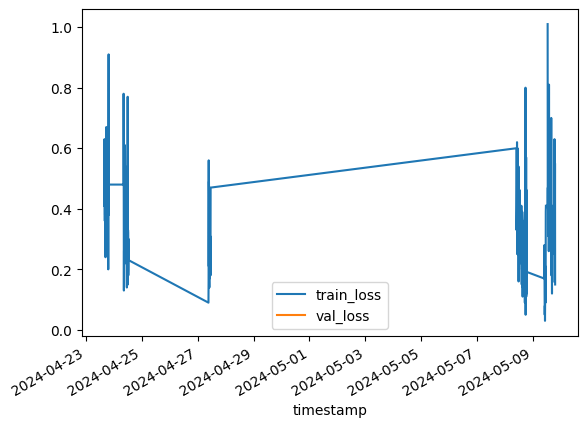

In [258]:
df = fix_dtypes(df)
df.plot(x='timestamp',y=['train_loss','val_loss'])

In [259]:
# This calculates which step each epoch starts at for drawing the graph's x-axis later

# Get the end of each epoch
df2 = df[['epoch','step']].groupby('epoch').agg({'step':'max'}).reset_index()
df2['epoch'] = df2['epoch'] + 1
df2['step'] = df2['step'] + 1
# insert epoch 0 start location: https://stackoverflow.com/a/24284680
df2.loc[-1] = [0,0]
df2.index = df2.index + 1 # shifting index to start at 0 instead of -1
df2 = df2.sort_index()    # resort by index
df2.head()

,epoch,step
0,0,0
1,1,667
2,2,1333
3,3,1999
4,4,2666


-40.7 1668.7


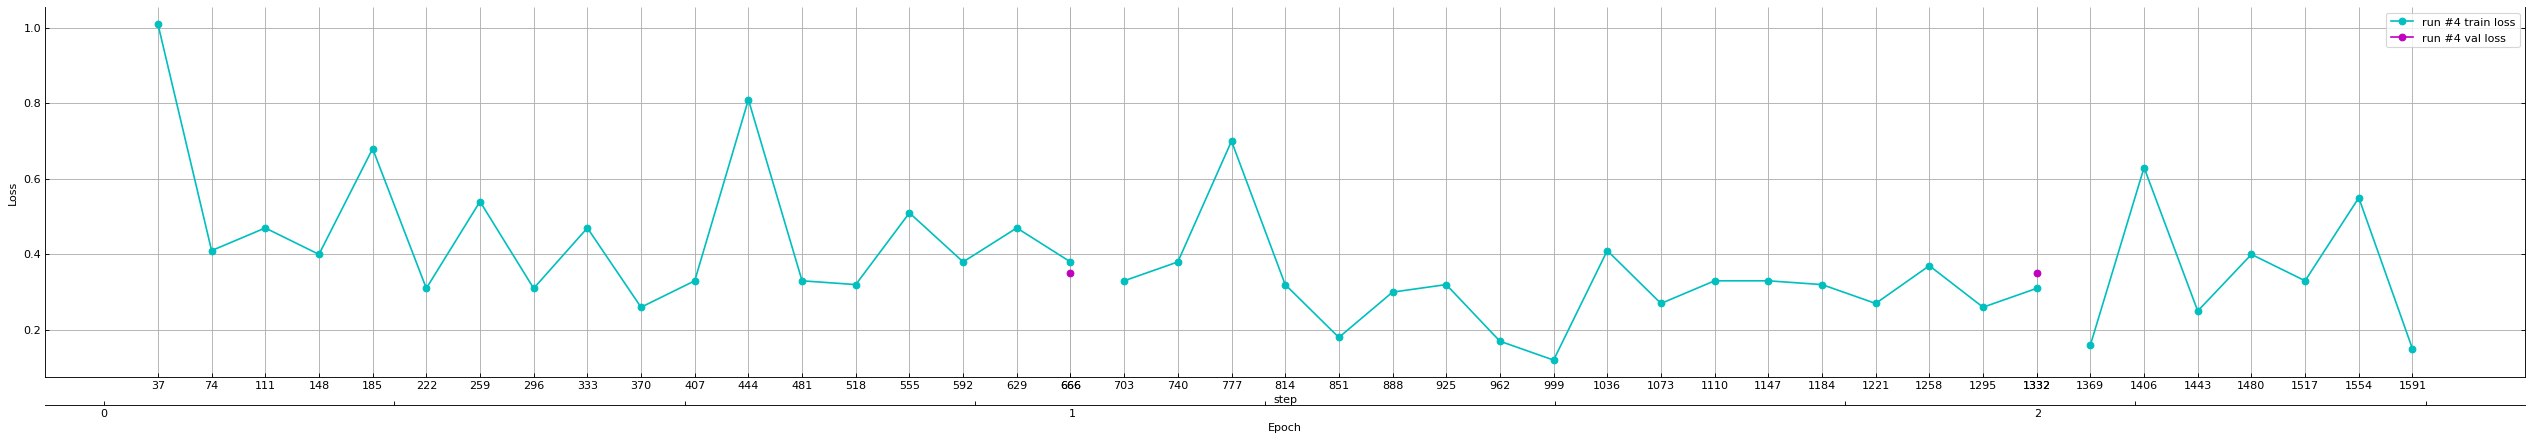

In [260]:
import matplotlib.ticker as ticker
from mpl_toolkits.axisartist.parasite_axes import SubplotHost # matplotlib v3.0.0+
#from mpl_toolkits.axes_grid.parasite_axes import SubplotHost
# may need to !pip install basemap if pip install matplotlib missed it in the prerequisites

# General code adapted from hierarchical axis labeling: https://stackoverflow.com/a/37950630

PLOT_RUN_NUM = '4'

fig1 = plt.figure(figsize=(40, 6), dpi=80)
ax1 = SubplotHost(fig1, 111)
fig1.add_subplot(ax1)

# x-label and ticks for training step
x = df['step']
xticklabels1 = df['step'].astype('string')

# x-label and ticks for training epoch
x2 = df2['epoch']
x2pos = df2['step']
xticklabels2 = df2['epoch'].astype('string')

# Data -- grouped by version and plotted individually below
#y = df['train_loss']

#===== First X-axis ========

# label all x-values (steps)
#ax1.set_xticks(x)
#ax1.set_xticklabels(xticklabels1, ha='left')
ax1.xaxis.set_label_text('Step') # doesn't seem to do anything
ax1.yaxis.set_label_text("Loss")

# Plot multiple y groups in one x,y column: https://stackoverflow.com/q/51053155
for key,grp in df.groupby(['version']):
    if key[0] != PLOT_RUN_NUM:
        continue # skip
    
    grp = fix_dtypes(grp)

    #plot values for each group on the graph
    #ax = grp.plot(ax=ax1, kind ='line',x='step',y='train_loss',label=key,title = "someTitle")
    grp.plot(x='step', y='train_loss', label=f'run #{key[0]} train loss', marker = 'o', linestyle='-', ax=ax1, color='c')\
        .axes.get_yaxis().set_visible(False) # hide overlapping y-axis
    
    grp.plot(x='step', y='val_loss', label=f'run #{key[0]} val loss', marker = 'o', linestyle='-', ax=ax1, color='m')\
        .axes.get_yaxis().set_visible(False) # hide overlapping y-axis

    # label only x-values (steps) used in this run, instead of displaying all labels, including those not applicable to this run
    ax1.set_xticks(grp['step'])
    ax1.set_xticklabels(grp['step'].astype('string'), ha='left')

#===== Second X-axis ========

ax2 = ax1.twiny()
offset = 0, -25 # Position of the second axis
new_axisline = ax2.get_grid_helper().new_fixed_axis
ax2.axis["bottom"] = new_axisline(loc="bottom", axes=ax2, offset=offset)
ax2.axis["bottom"].minor_ticks.set_ticksize(0) # hide minor ticks
ax2.axis["top"].set_visible(False)
ax2.xaxis.set_label_text("Epoch")

# Scale ax2 to match ax1 (twin axis solution): https://stackoverflow.com/a/43149956
xmin, xmax = ax1.get_xlim() # get x-axis limits
ax2.set_xlim(xmin, xmax)
print(xmin, xmax)

# sets ticks in relation to the first axis (x1)
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_locator(ticker.FixedLocator(x2pos))
ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(xticklabels2))

# sets ticks
#ax2.set_xticks(x2)
#ax2.set_xticklabels(xticklabels2)

# sets ticks at fixed intervals given in percentages of the x-axis (30%, 80% etc)
#ax2.set_xticks([0.0, 0.6, 1.0])
#ax2.xaxis.set_major_formatter(ticker.NullFormatter())
#ax2.xaxis.set_minor_locator(ticker.FixedLocator([0.3, 0.8]))
#ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['mammal', 'reptiles']))

ax1.grid(1)
plt.savefig(f'run{PLOT_RUN_NUM}graphloss_version39.png')
plt.show()
plt.close(fig1)